# Part 5: Exploratory Analysis

## Import Libraries

As always, we will import the libraries we intend to work with.

In [305]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from dotenv import load_dotenv
from datetime import date, datetime, timedelta
import glob
from ast import literal_eval
from collections import Counter
from tqdm.auto import tqdm
import pyarrow as pa
import matplotlib.pyplot as plt

### DRG Files

DRG codes are usually associated with big surgical procedures and are use for bulk payments (ex. Heart Attack Treatment). These cover all the material/labor/and stay for a procedure. Since CMS has data for these procedures, we will take a look at these first to see if we can match them with CMS rates. 

From the prior notebook, we will imported dataframes with DRG files. The drg variable are from our private insurance company while the cms variable is price information associated with certain drgs. Let us see if we have enough data to work with here.

In [306]:
drg = pd.read_parquet('D://Vignesh/Capstone/combined/drg_parquet/drg.parquet', engine='pyarrow')
cms = pd.read_csv('Hospital_Metrics/Medicare_Inpatient_Hospital_by_Provider_and_Service_2020.csv', encoding='windows-1252')

Lets take a look at all the billing types that fall under drg in the files that we collected from our prior file.

In [307]:
drg.head()

,billing_type,billing_code,negotiated_rates,ccn
0,MS-DRG,0001,135000.0,050327
1,MS-DRG,0002,135000.0,050327
2,MS-DRG,0003,9000.0,050327
3,MS-DRG,0004,9000.0,050327
4,MS-DRG,0005,135095.0,050327


We can see CCN has 0 in front of the value, same with billing code.

In [308]:
drg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9777 entries, 0 to 9776
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   billing_type      9777 non-null   object 
 1   billing_code      9777 non-null   object 
 2   negotiated_rates  9777 non-null   float64
 3   ccn               9777 non-null   object 
dtypes: float64(1), object(3)
memory usage: 305.7+ KB


Let us take a look at the cms file to see how we merge the data.

In [309]:
cms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165281 entries, 0 to 165280
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Rndrng_Prvdr_CCN           165281 non-null  int64  
 1   Rndrng_Prvdr_Org_Name      165281 non-null  object 
 2   Rndrng_Prvdr_St            165281 non-null  object 
 3   Rndrng_Prvdr_City          165281 non-null  object 
 4   Rndrng_Prvdr_State_Abrvtn  165281 non-null  object 
 5   Rndrng_Prvdr_State_FIPS    165281 non-null  int64  
 6   Rndrng_Prvdr_Zip5          165281 non-null  int64  
 7   Rndrng_Prvdr_RUCA          165281 non-null  float64
 8   Rndrng_Prvdr_RUCA_Desc     165281 non-null  object 
 9   DRG_Cd                     165281 non-null  int64  
 10  DRG_Desc                   165281 non-null  object 
 11  Tot_Dschrgs                165281 non-null  int64  
 12  Avg_Submtd_Cvrd_Chrg       165281 non-null  float64
 13  Avg_Tot_Pymt_Amt           16

We can change the types to int for both billing code and ccn columns.

In [310]:
drg = drg.astype({'billing_code': 'str','ccn':'int64'})
drg['billing_code'] = drg.apply(lambda row: row['billing_code'] if row['billing_code'].isdigit() else None, axis=1)

drg.head()

,billing_type,billing_code,negotiated_rates,ccn
0,MS-DRG,0001,135000.0,50327
1,MS-DRG,0002,135000.0,50327
2,MS-DRG,0003,9000.0,50327
3,MS-DRG,0004,9000.0,50327
4,MS-DRG,0005,135095.0,50327


In [311]:
drg.dropna(subset=['billing_code'],inplace=True)
drg = drg.astype({'billing_code': 'int64'})

In [312]:
merged = drg.merge(cms, how='inner', left_on=['ccn','billing_code'], right_on=['Rndrng_Prvdr_CCN','DRG_Cd'])

In [313]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   billing_type               799 non-null    object 
 1   billing_code               799 non-null    int64  
 2   negotiated_rates           799 non-null    float64
 3   ccn                        799 non-null    int64  
 4   Rndrng_Prvdr_CCN           799 non-null    int64  
 5   Rndrng_Prvdr_Org_Name      799 non-null    object 
 6   Rndrng_Prvdr_St            799 non-null    object 
 7   Rndrng_Prvdr_City          799 non-null    object 
 8   Rndrng_Prvdr_State_Abrvtn  799 non-null    object 
 9   Rndrng_Prvdr_State_FIPS    799 non-null    int64  
 10  Rndrng_Prvdr_Zip5          799 non-null    int64  
 11  Rndrng_Prvdr_RUCA          799 non-null    float64
 12  Rndrng_Prvdr_RUCA_Desc     799 non-null    object 
 13  DRG_Cd                     799 non-null    int64  

We only have 799 matching payments, and since each procedure widely varies in terms of price, this does not seem appropriate to use to compare metrics.

In [314]:
merged.head(10)

,billing_type,billing_code,negotiated_rates,ccn,Rndrng_Prvdr_CCN,Rndrng_Prvdr_Org_Name,Rndrng_Prvdr_St,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,DRG_Cd,DRG_Desc,Tot_Dschrgs,Avg_Submtd_Cvrd_Chrg,Avg_Tot_Pymt_Amt,Avg_Mdcr_Pymt_Amt
0,MS-DRG,3,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,3,"""ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRI...",23,1.090380e+06,211395.521740,179499.565220
1,MS-DRG,4,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,4,"TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NE...",18,9.469241e+05,153933.111110,138166.722220
2,MS-DRG,5,135095.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,5,LIVER TRANSPLANT WITH MCC OR INTESTINAL TRANSP...,20,1.083387e+06,143484.300000,129179.250000
3,MS-DRG,11,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,11,"TRACHEOSTOMY FOR FACE, MOUTH & NECK DIAGNOSES ...",12,3.949202e+05,68277.750000,59581.916667
4,MS-DRG,23,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,23,CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE COM...,21,3.829408e+05,66471.142857,59667.809524
5,MS-DRG,25,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,25,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,26,3.617819e+05,50147.307692,45107.153846
6,MS-DRG,27,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,27,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,21,1.635656e+05,26104.333333,23466.095238
7,MS-DRG,64,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,64,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,43,1.982089e+05,26364.906977,21787.767442
8,MS-DRG,65,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,65,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,30,8.148413e+04,11613.433333,9173.800000
9,MS-DRG,70,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,70,NONSPECIFIC CEREBROVASCULAR DISORDERS W MCC,19,1.361019e+05,20190.473684,15949.315789


In [315]:
merged['ccn'].nunique()

15

## Other Procedure Codes:

It seems with only 15 hospitals and varying number of DRGs, we will not be able to use this data set to learn meaningful information about how hospital metrics affect negotiated metrics. So lets instead use other procedures that are more common. Here is a table of a list of procedures and which CMS metric it could be correlated with. Sode of the procedure codes I used deduction based off the criteria.

| Code Type | Code Value | Description | Associated CMS Metric | Metric Details
| --- | --- | --- | --- | --- |
| CPT | 36556 | Under Insertion of Central Venous Access Device | HAI_1 | Central Line Associated Bloodstream Infection
| CPT | 51701 | Under Introduction Procedures on the Bladder | HAI_2 | Catheter Associated Urinary Tract Infections
| CPT | 51702 | Under Introduction Procedures on the Bladder | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | A4314 | Insertion tray with drainage bag with indwelling catheter, Foley type, 2-way latex with coating (Teflon, silicone, silicone elastomer or hydrophilic, etc.) | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | A4315 | Insertion tray with drainage bag with indwelling catheter, Foley type, 2-way, all silicone | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | G9312 | Surgical site infection | HAI_3 | Surgical Site Infection - Colon Surgery
| CPT | 58150 | Under Hysterectomy Procedures | HAI_4 | Surgical Site Infection - Abdominal Hysterectomy
| CPT | 15920 | Under Pressure Ulcers (Decubitus Ulcers) Procedures | PSI-3 | Pressure Ulcer Rate
| CPT | 35800 | Under Repair, Excision, Exploration, Revision Procedures on Arteries and Veins | PSI-9 | Postoperative hemorrhage or hematoma rate
| HCPCS | J1650 | Injection, enoxaparin sodium, 10 mg | PSI-12 | Perioperative pulmonary embolism or deep vein thrombosis rate
| HCPCS | C9604 | Percutaneous transluminal revascularization of or through coronary artery bypass graft (internal mammary, free arterial, venous), any combination of drug-eluting intracoronary stent, atherectomy and angioplasty, including distal protection when performed | MORT_30_CABG | Death rate for CABG surgery patients


PSI 90 is a composite metric of all PSI scores (patient safety scores). Since it should be highly correlated with all surgeries, I think it would be appropriate to add for CCN availible.

The following are some of the most common CPT codes used within hospital systems, in terms of cost to US hospitals. These do not include procedures like a 15 minute visit to a family practiciner, which I would consider outpatient. I narrowed it down to mostly inpatient procedures, but some of these can be applied to both setting, such as a CBC. I tried to vary the procedures based on expertise of labor, for example dialysis is a more complex procedure vs a comprehensive metabolic panel. 

| Code Type | Code Value | Description |
| --- | --- | --- |
| CPT | 71045 | X-RAY EXAM CHEST 1 VIEW |
| CPT | 99285 | EMERGENCY DEPT VISIT |
| CPT | 85025 | COMPLETE CBC W/AUTO DIFF WBC |
| CPT | 80053 | COMPREHEN METABOLIC PANEL |
| CPT | 90999 | DIALYSIS PROCEDURE |
| CPT | 36415 | ROUTINE VENIPUNCTURE |

In [316]:
code_values = [['CPT','36556'],['CPT','51701'],['CPT','51702'],['HCPCS','A4314'],
                ['HCPCS','A4315'],['HCPCS','G9312'],['CPT','58150'],['CPT','15920'],
                ['CPT','35800'],['HCPCS','J1650'],['HCPCS','C9604'], 
                ['CPT','71045'], ['CPT','99285'], ['CPT','85025'], 
                ['CPT','80053'],['CPT','90999'],['CPT','36415']]

cpt = pd.read_parquet('D:\Vignesh\Capstone\combined\cpt_parquet\cpt.parquet')
hcpcs = pd.read_parquet('D:\Vignesh\Capstone\combined\hcpcs_parquet\hcpcs.parquet')

Similar to the DRG files, lets adjust the types before we merge files.

In [317]:
cpt.head()

,billing_type,billing_code,negotiated_rates,ccn
0,CPT,0001A,16.94,290003
1,CPT,0001U,576.00,290003
2,CPT,0002A,28.39,290003
3,CPT,0002M,402.72,290003
4,CPT,0002U,20.00,290003


In [318]:
cpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14771907 entries, 0 to 14771906
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   billing_type      object 
 1   billing_code      object 
 2   negotiated_rates  float64
 3   ccn               object 
dtypes: float64(1), object(3)
memory usage: 450.8+ MB


Since the files we created from the previous notebook are divided into different code groups, this for loop will go through both dataframes and collect the rows that match with codes we are interested in from the United Insurance company files.

In [319]:
df = pd.DataFrame(columns=['billing_type','billing_code','negotiated_rates','ccn'])

for [code_type, value] in code_values:
    if code_type == 'CPT':
        temp = cpt[cpt['billing_code'] == value]
        df = pd.concat([df,temp], axis=0, ignore_index=True)
    else:
        temp = hcpcs[hcpcs['billing_code'] == value]
        df = pd.concat([df,temp], axis=0, ignore_index=True)

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20208 entries, 0 to 20207
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   billing_type      20208 non-null  object 
 1   billing_code      20208 non-null  object 
 2   negotiated_rates  20208 non-null  float64
 3   ccn               20208 non-null  object 
dtypes: float64(1), object(3)
memory usage: 631.6+ KB


In [321]:
df.head()

,billing_type,billing_code,negotiated_rates,ccn
0,CPT,36556,221.30,290003
1,CPT,36556,239.31,290039
2,CPT,36556,92.87,290039
3,CPT,36556,309.82,290003
4,CPT,36556,221.30,290007


### Infection Rates

Unfortunately, the cms file we used earlier only has DRG codes and metrics associated with it; however, CMS has hospital metrics. Some of the more key metrics are infection rates associated with different pools of procedures and safety metrics with each hospital. Lets try to merge these files on hospital ccn with the insurance company negotiated rates.

In [322]:
infections = pd.read_csv('Hospital_Metrics\Healthcare_Associated_Infections-Hospital.csv', 
                         usecols=['Facility ID','Measure ID','Score'])

In [323]:
infections.head()

,Facility ID,Measure ID,Score
0,010001,HAI_1_CILOWER,0.289
1,010001,HAI_1_CIUPPER,1.307
2,010001,HAI_1_DOPC,10024
3,010001,HAI_1_ELIGCASES,10.597
4,010001,HAI_1_NUMERATOR,7


In [324]:
inf_piv = infections.pivot(index='Facility ID',columns='Measure ID', values='Score').reset_index()
inf_piv.head()

Measure ID,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,HAI_2_CIUPPER,HAI_2_DOPC,...,HAI_5_DOPC,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_CILOWER,HAI_6_CIUPPER,HAI_6_DOPC,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR
0,010001,0.289,1.307,10024,10.597,7,0.661,0.140,0.570,17731,...,101908,9.412,8,0.850,0.492,0.868,101451,72.686,48,0.660
1,010005,1.791,6.741,3713,2.450,9,3.673,0.487,2.498,8670,...,38413,1.999,0,0.000,0.419,1.575,35686,10.484,9,0.858
2,010006,0.307,1.575,7318,7.924,6,0.757,0.050,0.534,11755,...,62709,4.164,6,1.441,0.015,0.292,54159,22.618,2,0.088
3,010007,Not Available,Not Available,268,0.165,0,Not Available,Not Available,Not Available,1417,...,5484,0.132,0,Not Available,0.023,2.296,5413,2.148,1,0.466
4,010008,Not Available,Not Available,14,0.008,0,Not Available,Not Available,Not Available,488,...,2171,0.051,0,Not Available,Not Available,Not Available,2171,0.398,0,Not Available


In [325]:
col = inf_piv.columns.to_list()
col

['Facility ID',
 'HAI_1_CILOWER',
 'HAI_1_CIUPPER',
 'HAI_1_DOPC',
 'HAI_1_ELIGCASES',
 'HAI_1_NUMERATOR',
 'HAI_1_SIR',
 'HAI_2_CILOWER',
 'HAI_2_CIUPPER',
 'HAI_2_DOPC',
 'HAI_2_ELIGCASES',
 'HAI_2_NUMERATOR',
 'HAI_2_SIR',
 'HAI_3_CILOWER',
 'HAI_3_CIUPPER',
 'HAI_3_DOPC',
 'HAI_3_ELIGCASES',
 'HAI_3_NUMERATOR',
 'HAI_3_SIR',
 'HAI_4_CILOWER',
 'HAI_4_CIUPPER',
 'HAI_4_DOPC',
 'HAI_4_ELIGCASES',
 'HAI_4_NUMERATOR',
 'HAI_4_SIR',
 'HAI_5_CILOWER',
 'HAI_5_CIUPPER',
 'HAI_5_DOPC',
 'HAI_5_ELIGCASES',
 'HAI_5_NUMERATOR',
 'HAI_5_SIR',
 'HAI_6_CILOWER',
 'HAI_6_CIUPPER',
 'HAI_6_DOPC',
 'HAI_6_ELIGCASES',
 'HAI_6_NUMERATOR',
 'HAI_6_SIR']

In [326]:
inf_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4848 entries, 0 to 4847
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Facility ID      4848 non-null   object
 1   HAI_1_CILOWER    4848 non-null   object
 2   HAI_1_CIUPPER    4848 non-null   object
 3   HAI_1_DOPC       4848 non-null   object
 4   HAI_1_ELIGCASES  4848 non-null   object
 5   HAI_1_NUMERATOR  4848 non-null   object
 6   HAI_1_SIR        4848 non-null   object
 7   HAI_2_CILOWER    4848 non-null   object
 8   HAI_2_CIUPPER    4848 non-null   object
 9   HAI_2_DOPC       4848 non-null   object
 10  HAI_2_ELIGCASES  4848 non-null   object
 11  HAI_2_NUMERATOR  4848 non-null   object
 12  HAI_2_SIR        4848 non-null   object
 13  HAI_3_CILOWER    4848 non-null   object
 14  HAI_3_CIUPPER    4848 non-null   object
 15  HAI_3_DOPC       4848 non-null   object
 16  HAI_3_ELIGCASES  4848 non-null   object
 17  HAI_3_NUMERATOR  4848 non-null   

### Safety Metrics

Let us do the same with safety metrics and the associated file pulled from the CMS directory of hospital metrics.

In [327]:
safety = pd.read_csv('Hospital_Metrics\CMS_PSI_6_decimal_file.csv', 
                         usecols=['Facility ID','Measure ID','Rate'])

In [328]:
safety.head()

,Facility ID,Measure ID,Rate
0,010001,PSI_03,0.231881
1,010001,PSI_06,0.167117
2,010001,PSI_08,0.095461
3,010001,PSI_09,2.330697
4,010001,PSI_10,0.609540


In [329]:
saf_piv = safety.pivot(index='Facility ID',columns='Measure ID',values='Rate').reset_index()
saf_piv.head()

Measure ID,Facility ID,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,PSI_13,PSI_14,PSI_15,PSI_90
0,010001,0.231881,0.167117,0.095461,2.330697,0.609540,8.923957,3.328297,5.980974,0.649012,1.209750,1.005236
1,010005,0.859076,0.173883,0.057663,2.075276,0.756613,6.869380,2.542284,3.440264,0.762277,0.866989,0.908322
2,010006,1.829317,0.261801,0.046622,3.457041,0.651895,3.893786,2.798522,3.721339,0.675144,1.334372,1.099465
3,010007,0.319664,0.183425,0.072035,2.366388,0.914303,6.005962,3.799432,4.048369,Not Available,1.018783,0.993102
4,010008,0.498143,0.185437,0.073861,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available


Lets merge these files on CCN number.

In [330]:
measure = inf_piv.merge(saf_piv, how='inner', on='Facility ID')
measure.head()

Measure ID,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,HAI_2_CIUPPER,HAI_2_DOPC,...,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,PSI_13,PSI_14,PSI_15,PSI_90
0,010001,0.289,1.307,10024,10.597,7,0.661,0.140,0.570,17731,...,0.167117,0.095461,2.330697,0.609540,8.923957,3.328297,5.980974,0.649012,1.209750,1.005236
1,010005,1.791,6.741,3713,2.450,9,3.673,0.487,2.498,8670,...,0.173883,0.057663,2.075276,0.756613,6.869380,2.542284,3.440264,0.762277,0.866989,0.908322
2,010006,0.307,1.575,7318,7.924,6,0.757,0.050,0.534,11755,...,0.261801,0.046622,3.457041,0.651895,3.893786,2.798522,3.721339,0.675144,1.334372,1.099465
3,010007,Not Available,Not Available,268,0.165,0,Not Available,Not Available,Not Available,1417,...,0.183425,0.072035,2.366388,0.914303,6.005962,3.799432,4.048369,Not Available,1.018783,0.993102
4,010008,Not Available,Not Available,14,0.008,0,Not Available,Not Available,Not Available,488,...,0.185437,0.073861,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available


In [331]:
measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 0 to 4812
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Facility ID      4813 non-null   object
 1   HAI_1_CILOWER    4813 non-null   object
 2   HAI_1_CIUPPER    4813 non-null   object
 3   HAI_1_DOPC       4813 non-null   object
 4   HAI_1_ELIGCASES  4813 non-null   object
 5   HAI_1_NUMERATOR  4813 non-null   object
 6   HAI_1_SIR        4813 non-null   object
 7   HAI_2_CILOWER    4813 non-null   object
 8   HAI_2_CIUPPER    4813 non-null   object
 9   HAI_2_DOPC       4813 non-null   object
 10  HAI_2_ELIGCASES  4813 non-null   object
 11  HAI_2_NUMERATOR  4813 non-null   object
 12  HAI_2_SIR        4813 non-null   object
 13  HAI_3_CILOWER    4813 non-null   object
 14  HAI_3_CIUPPER    4813 non-null   object
 15  HAI_3_DOPC       4813 non-null   object
 16  HAI_3_ELIGCASES  4813 non-null   object
 17  HAI_3_NUMERATOR  4813 non-null   

In [332]:
measure.dtypes

Measure ID
Facility ID        object
HAI_1_CILOWER      object
HAI_1_CIUPPER      object
HAI_1_DOPC         object
HAI_1_ELIGCASES    object
HAI_1_NUMERATOR    object
HAI_1_SIR          object
HAI_2_CILOWER      object
HAI_2_CIUPPER      object
HAI_2_DOPC         object
HAI_2_ELIGCASES    object
HAI_2_NUMERATOR    object
HAI_2_SIR          object
HAI_3_CILOWER      object
HAI_3_CIUPPER      object
HAI_3_DOPC         object
HAI_3_ELIGCASES    object
HAI_3_NUMERATOR    object
HAI_3_SIR          object
HAI_4_CILOWER      object
HAI_4_CIUPPER      object
HAI_4_DOPC         object
HAI_4_ELIGCASES    object
HAI_4_NUMERATOR    object
HAI_4_SIR          object
HAI_5_CILOWER      object
HAI_5_CIUPPER      object
HAI_5_DOPC         object
HAI_5_ELIGCASES    object
HAI_5_NUMERATOR    object
HAI_5_SIR          object
HAI_6_CILOWER      object
HAI_6_CIUPPER      object
HAI_6_DOPC         object
HAI_6_ELIGCASES    object
HAI_6_NUMERATOR    object
HAI_6_SIR          object
PSI_03             object
P

Here lets change some of these object data types to numerics.

In [333]:
col = measure.columns.to_list()
col.remove('Facility ID')
for c in col:
    measure[c] = pd.to_numeric(measure[c],errors='coerce')
measure['Facility ID'] = pd.to_numeric(measure['Facility ID'],errors='coerce')
measure.dropna(subset=['Facility ID'],inplace=True)
measure.drop_duplicates(subset=['Facility ID'],inplace=True)
measure = measure.astype({'Facility ID':'int64'})
types = {c:'float64' for c in col}
measure = measure.astype(types)


### Cost/Hospital Data

We also have some cost data and hospital metrics. Lets combine this data as well.

In [334]:
cost = pd.read_csv('Hospital_Metrics\Hospital_Cost_Report_2019.csv', 
                         usecols=['Provider CCN','City', 'State Code', 'Zip Code',
                                'Rural Versus Urban','CCN Facility Type',
                                'Fiscal Year Begin Date', 'Fiscal Year End Date',
                                'Number of Interns and Residents (FTE)', 'Number of Beds',
                                'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
                                'Total Discharges (V + XVIII + XIX + Unknown)',
                                'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
                                'Hospital Number of Beds For Adults &amp; Peds',
                                'Hospital Total Bed Days Available For Adults &amp; Peds',
                                'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds'
                                ])
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds
0,40018,VAN BUREN,AR,72956,U,STH,11/01/2018,12/31/2018,NaN,39.0,168.0,481.0,444.0,31.0,1891.0,168.0
1,100044,STUART,FL,34995,U,STH,10/01/2018,12/31/2018,NaN,521.0,26952.0,31535.0,26412.0,447.0,41124.0,26952.0
2,450090,GAINSVILLE,TX,76240-,R,STH,10/01/2018,11/30/2018,NaN,36.0,175.0,5205.0,534.0,31.0,1708.0,175.0
3,40055,FORT SMITH,AR,72901,U,STH,11/01/2018,12/31/2018,4.26,320.0,2077.0,10556.0,9015.0,289.0,17629.0,2077.0
4,201302,BOOTHBAY HARBOR,ME,04538-,R,CAH,10/01/2018,12/31/2018,NaN,25.0,382.0,19312.0,1377.0,21.0,7665.0,382.0


In [335]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 16 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Provider CCN                                                                 6118 non-null   int64  
 1   City                                                                         6118 non-null   object 
 2   State Code                                                                   6118 non-null   object 
 3   Zip Code                                                                     6118 non-null   object 
 4   Rural Versus Urban                                                           6049 non-null   object 
 5   CCN Facility Type                                                            6118 non-null   object 
 6   Fiscal Year Begin Date                  

Since the data in this table has dates from which they were collected, some of this data needs to annualized. In the documentation it is clear that this data can be spread out between 3 months to a year. So lets standardize the data for the time period it is associated with. Some metrics do not need to be changed, such has number of beds or interns because these stay constant regardless of the time period.

In [336]:
cost[['Fiscal Year Begin Date', 'Fiscal Year End Date']]= cost[['Fiscal Year Begin Date', 'Fiscal Year End Date']].apply(pd.to_datetime)
cost['Zip Code'] = cost['Zip Code'].str[:5]
cat = ['City','State Code','Zip Code', 'Rural Versus Urban', 'CCN Facility Type']
types = {c:'category' for c in cat}
cost = cost.astype(types)
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,168.0,481.0,444.0,31.0,1891.0,168.0
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,26952.0,31535.0,26412.0,447.0,41124.0,26952.0
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,175.0,5205.0,534.0,31.0,1708.0,175.0
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,2077.0,10556.0,9015.0,289.0,17629.0,2077.0
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,382.0,19312.0,1377.0,21.0,7665.0,382.0


In [337]:
cost['Time Period'] = cost['Fiscal Year End Date'] - cost['Fiscal Year Begin Date']
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,168.0,481.0,444.0,31.0,1891.0,168.0,60 days
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,26952.0,31535.0,26412.0,447.0,41124.0,26952.0,91 days
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,175.0,5205.0,534.0,31.0,1708.0,175.0,60 days
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,2077.0,10556.0,9015.0,289.0,17629.0,2077.0,60 days
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,382.0,19312.0,1377.0,21.0,7665.0,382.0,91 days


In [338]:
columns_to_convert = ['Total Discharges (V + XVIII + XIX + Unknown)', 'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
                      'Hospital Total Bed Days Available For Adults &amp; Peds',
                      'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
                      'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds']

for column in columns_to_convert:
    cost[column] = cost[column] * (pd.Timedelta('365 days') / cost['Time Period'])

In [339]:
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,1022.000000,2926.083333,2701.000000,31.0,11503.583333,1022.000000,60 days
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,108104.175824,126486.538462,105938.241758,447.0,164947.912088,108104.175824,91 days
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,1064.583333,31663.750000,3248.500000,31.0,10390.333333,1064.583333,60 days
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,12635.083333,64215.666667,54841.250000,289.0,107243.083333,12635.083333,60 days
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,1532.197802,77460.219780,5523.131868,21.0,30744.230769,1532.197802,91 days


In [340]:
cost_measure = measure.merge(cost,how='inner',left_on='Facility ID',right_on='Provider CCN')

In [341]:
cost_measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668 entries, 0 to 4667
Data columns (total 65 columns):
 #   Column                                                                       Non-Null Count  Dtype          
---  ------                                                                       --------------  -----          
 0   Facility ID                                                                  4668 non-null   int64          
 1   HAI_1_CILOWER                                                                1896 non-null   float64        
 2   HAI_1_CIUPPER                                                                2098 non-null   float64        
 3   HAI_1_DOPC                                                                   3736 non-null   float64        
 4   HAI_1_ELIGCASES                                                              3736 non-null   float64        
 5   HAI_1_NUMERATOR                                                              3736 non-null

In [342]:
cost_measure['Facility ID'].nunique() 

4595

In [343]:
df = df.astype({'ccn':'int64'})
final = df.merge(right=cost_measure,how='inner',left_on='ccn',right_on='Facility ID')
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19778
Data columns (total 69 columns):
 #   Column                                                                       Non-Null Count  Dtype          
---  ------                                                                       --------------  -----          
 0   billing_type                                                                 19779 non-null  object         
 1   billing_code                                                                 19779 non-null  object         
 2   negotiated_rates                                                             19779 non-null  float64        
 3   ccn                                                                          19779 non-null  int64          
 4   Facility ID                                                                  19779 non-null  int64          
 5   HAI_1_CILOWER                                                                15260 non-n

In [344]:
final.describe()

,negotiated_rates,ccn,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,...,Provider CCN,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
count,19779.000000,19779.000000,19779.000000,15260.00000,16163.000000,19407.000000,19407.000000,19407.000000,16163.000000,15967.000000,...,19779.000000,9953.000000,19779.000000,19779.000000,19779.000000,19760.000000,19760.000000,19760.000000,19779.000000,19779
mean,2480.240888,194610.881794,194610.881794,0.52568,2.002382,12434.313650,12.910460,12.576235,0.985094,0.408412,...,194610.881794,129.314692,346.960716,18270.115001,105131.283337,68381.652201,281.055567,102070.072293,18270.115001,360 days 16:55:50.462611864
std,41772.468869,150512.000021,150512.000021,0.45294,1.187761,15914.518236,17.612264,20.002346,0.695172,0.334570,...,150512.000021,185.602377,407.207628,21928.491647,120881.925927,85455.607387,329.219638,120130.968787,21928.491647,30 days 13:44:45.237617519
min,0.300000,10001.000000,10001.000000,0.00400,0.403000,4.000000,0.001000,0.000000,0.000000,0.003000,...,10001.000000,0.080000,2.000000,18.049451,449.000000,37.101648,2.000000,732.005495,18.049451,61 days 00:00:00
25%,14.775000,60113.000000,60113.000000,0.21400,1.255000,2945.000000,2.414000,1.000000,0.561000,0.160000,...,60113.000000,16.890000,124.000000,5703.000000,36815.865385,18056.469780,107.000000,36600.000000,5703.000000,364 days 00:00:00
50%,61.000000,100287.000000,100287.000000,0.42600,1.633000,6995.000000,6.365000,6.000000,0.863000,0.320000,...,100287.000000,44.080000,236.000000,12725.000000,67098.832418,44492.000000,198.000000,72102.541209,12725.000000,364 days 00:00:00
75%,297.315000,300001.000000,300001.000000,0.76800,2.387000,14746.000000,15.166000,15.000000,1.257000,0.605000,...,300001.000000,166.050000,410.000000,22906.758242,123082.000000,82959.285714,331.000000,120729.000000,22906.758242,365 days 00:00:00
max,999999.990000,670076.000000,670076.000000,4.08100,11.146000,89310.000000,95.144000,118.000000,5.869000,2.211000,...,670076.000000,1285.530000,2735.000000,131197.445055,815529.326923,538474.271978,2245.000000,821676.167582,131197.445055,365 days 00:00:00


In [345]:
final.drop(columns=['Facility ID', 'Provider CCN', 'Time Period'], inplace=True)
final['Procedure'] = final['billing_type'] + ' ' + final['billing_code']


In [346]:
col = final.columns.to_list()
col

['billing_type',
 'billing_code',
 'negotiated_rates',
 'ccn',
 'HAI_1_CILOWER',
 'HAI_1_CIUPPER',
 'HAI_1_DOPC',
 'HAI_1_ELIGCASES',
 'HAI_1_NUMERATOR',
 'HAI_1_SIR',
 'HAI_2_CILOWER',
 'HAI_2_CIUPPER',
 'HAI_2_DOPC',
 'HAI_2_ELIGCASES',
 'HAI_2_NUMERATOR',
 'HAI_2_SIR',
 'HAI_3_CILOWER',
 'HAI_3_CIUPPER',
 'HAI_3_DOPC',
 'HAI_3_ELIGCASES',
 'HAI_3_NUMERATOR',
 'HAI_3_SIR',
 'HAI_4_CILOWER',
 'HAI_4_CIUPPER',
 'HAI_4_DOPC',
 'HAI_4_ELIGCASES',
 'HAI_4_NUMERATOR',
 'HAI_4_SIR',
 'HAI_5_CILOWER',
 'HAI_5_CIUPPER',
 'HAI_5_DOPC',
 'HAI_5_ELIGCASES',
 'HAI_5_NUMERATOR',
 'HAI_5_SIR',
 'HAI_6_CILOWER',
 'HAI_6_CIUPPER',
 'HAI_6_DOPC',
 'HAI_6_ELIGCASES',
 'HAI_6_NUMERATOR',
 'HAI_6_SIR',
 'PSI_03',
 'PSI_06',
 'PSI_08',
 'PSI_09',
 'PSI_10',
 'PSI_11',
 'PSI_12',
 'PSI_13',
 'PSI_14',
 'PSI_15',
 'PSI_90',
 'City',
 'State Code',
 'Zip Code',
 'Rural Versus Urban',
 'CCN Facility Type',
 'Fiscal Year Begin Date',
 'Fiscal Year End Date',
 'Number of Interns and Residents (FTE)',
 'Number o

## Cleaning

We are going to remove some columns that are redundant. For example each PSI metric is broken down into its component parts in the original CMS table. We will just work with the final score given to each PSI value.

In [347]:
col_work = ['ccn', 
            'Procedure',
            'State Code',
            'Rural Versus Urban',
            'PSI_03',
            'PSI_06',
            'PSI_08',
            'PSI_09',
            'PSI_10',
            'PSI_11',
            'PSI_12',
            'PSI_13',
            'PSI_14',
            'PSI_15',
            'PSI_90',
            'HAI_1_SIR',
            'HAI_2_SIR',
            'HAI_3_SIR',
            'HAI_4_SIR',
            'HAI_5_SIR',
            'HAI_6_SIR',
            'Number of Interns and Residents (FTE)',
            'Number of Beds',
            'Total Discharges (V + XVIII + XIX + Unknown)',
            'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
            'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
            'Hospital Number of Beds For Adults &amp; Peds',
            'Hospital Total Bed Days Available For Adults &amp; Peds',
            'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
            'negotiated_rates']

df = final[col_work]
df.head()

,ccn,Procedure,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,...,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates
0,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,221.30
1,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,309.82
2,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,273.50
3,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,106.14
4,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,171.56


In [348]:
df.info()
df = df.astype({'ccn':'category', 'Procedure':'category'})

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19778
Data columns (total 30 columns):
 #   Column                                                                       Non-Null Count  Dtype   
---  ------                                                                       --------------  -----   
 0   ccn                                                                          19779 non-null  int64   
 1   Procedure                                                                    19779 non-null  object  
 2   State Code                                                                   19779 non-null  category
 3   Rural Versus Urban                                                           19779 non-null  category
 4   PSI_03                                                                       18574 non-null  float64 
 5   PSI_06                                                                       18574 non-null  float64 
 6   PSI_08                        

In [349]:
missing_mean = ['PSI_03', 'PSI_06', 'PSI_08', 'PSI_09', 'PSI_10', 'PSI_11', 'PSI_12', 'PSI_13', 'PSI_14', 'PSI_15', 'PSI_90',
                'HAI_1_SIR', 'HAI_2_SIR', 'HAI_3_SIR', 'HAI_5_SIR', 'HAI_6_SIR',
                'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds', 
                'Hospital Number of Beds For Adults &amp; Peds', 
                'Hospital Total Bed Days Available For Adults &amp; Peds']
missing_zero = ['Number of Interns and Residents (FTE)']
remove = ['HAI_4_SIR']

<Axes: xlabel='Procedure', ylabel='negotiated_rates'>

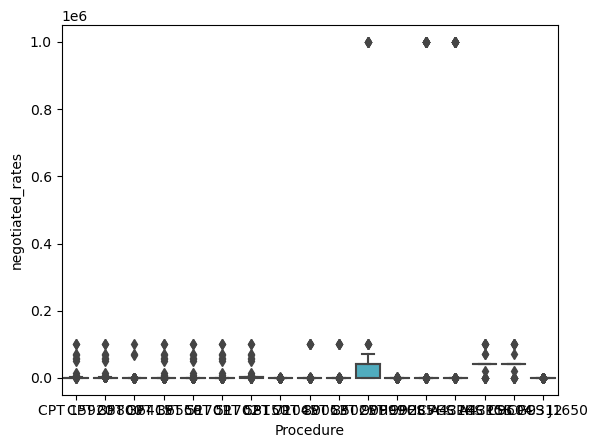

In [350]:
sns.boxplot(x="Procedure", y="negotiated_rates",
            data=df)

In [351]:
df2 = df.groupby(['Procedure'])['negotiated_rates']

In [352]:
df2.describe()

,count,mean,std,min,25%,50%,75%,max
Procedure,,,,,,,,
CPT 15920,1385.0,1193.742116,5277.226813,0.57,600.5000,754.810,982.4800,99999.00
CPT 35800,1373.0,1298.682251,5300.364988,0.57,635.8100,851.470,1116.7900,99999.00
CPT 36415,929.0,262.645188,4611.965008,0.30,1.8000,3.000,4.2400,99999.00
CPT 36556,1856.0,563.168260,4586.026572,0.57,160.8900,251.830,343.3925,99999.00
CPT 51701,1860.0,344.716629,4588.884211,0.57,37.2875,54.245,74.9500,99999.00
CPT 51702,1864.0,361.296196,4583.017383,0.57,40.4000,73.760,100.7500,99999.00
CPT 58150,1386.0,1748.699149,5266.192033,0.57,1021.1125,1260.930,1604.5450,99999.00
CPT 71045,2605.0,21.837259,58.435802,0.57,10.3600,17.020,25.9800,2897.00
CPT 80053,1050.0,395.139533,6163.078289,0.87,6.2000,8.620,14.6100,99999.99


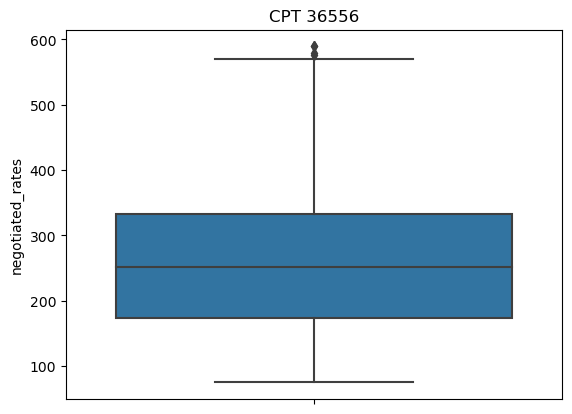

1671/1856 data points remain for CPT 36556.


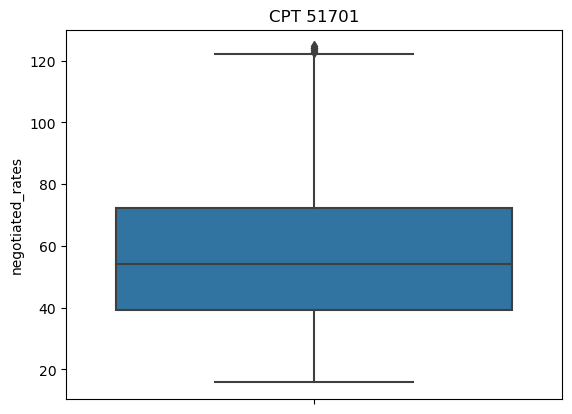

1674/1860 data points remain for CPT 51701.


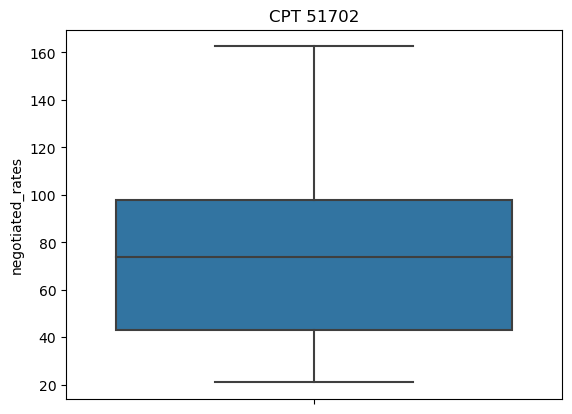

1676/1864 data points remain for CPT 51702.


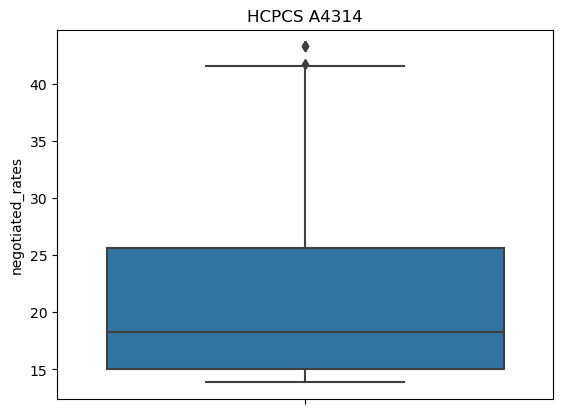

787/872 data points remain for HCPCS A4314.


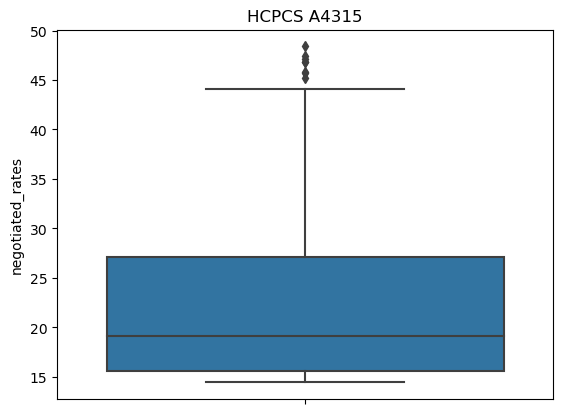

784/869 data points remain for HCPCS A4315.


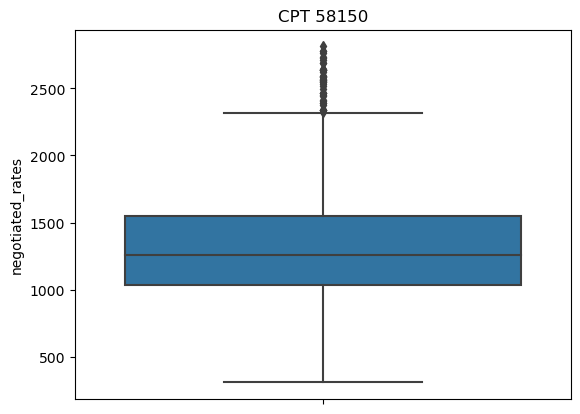

1248/1386 data points remain for CPT 58150.


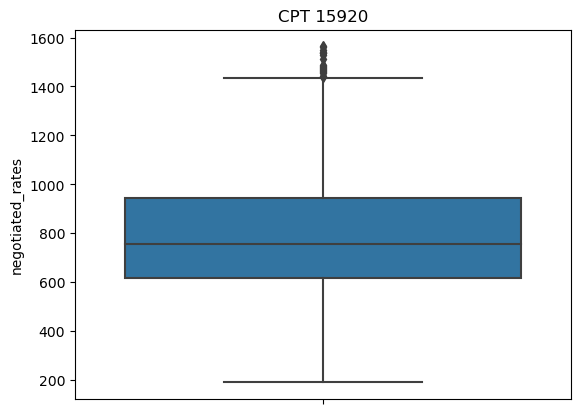

1245/1385 data points remain for CPT 15920.


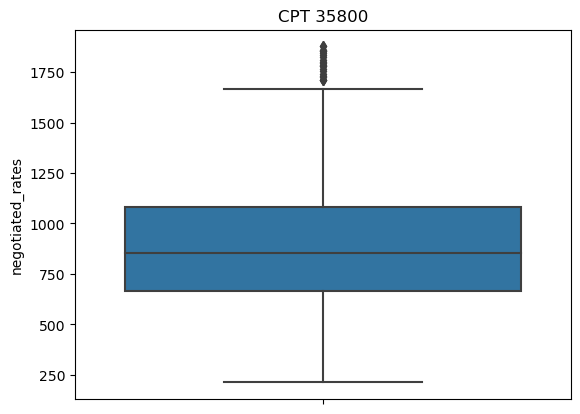

1235/1373 data points remain for CPT 35800.


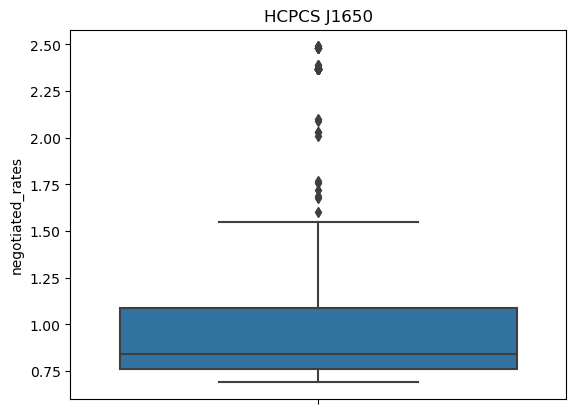

646/711 data points remain for HCPCS J1650.


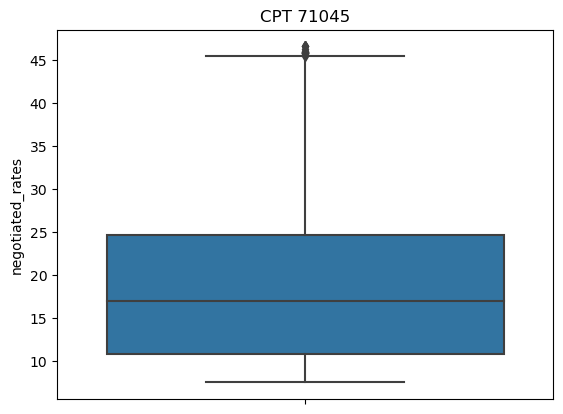

2345/2605 data points remain for CPT 71045.


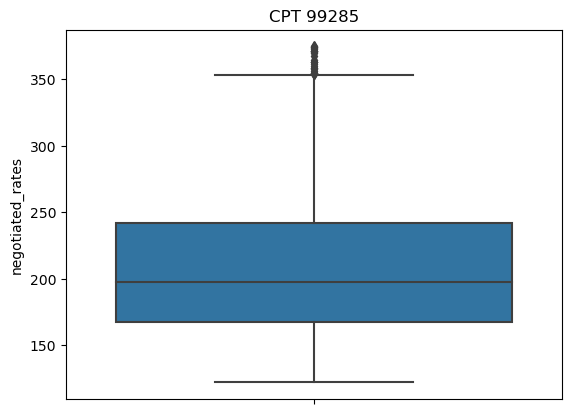

1604/1784 data points remain for CPT 99285.


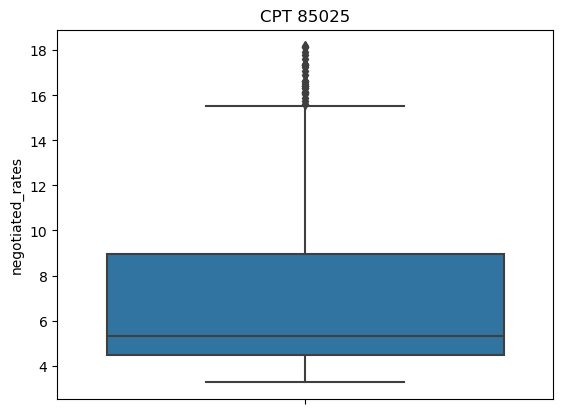

1008/1077 data points remain for CPT 85025.


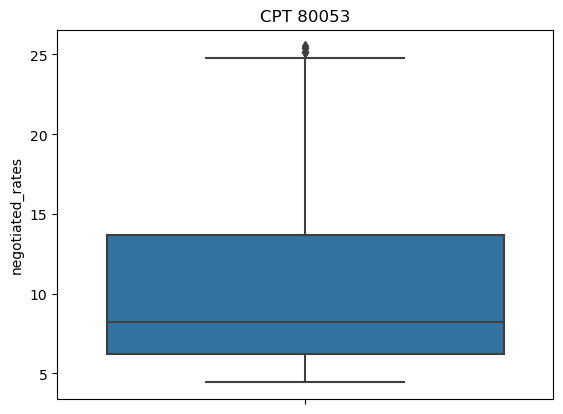

978/1050 data points remain for CPT 80053.


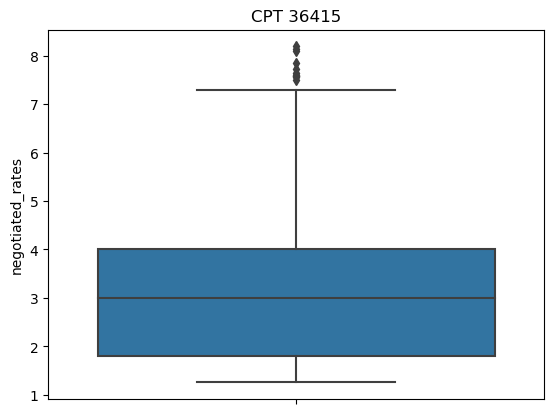

853/929 data points remain for CPT 36415.


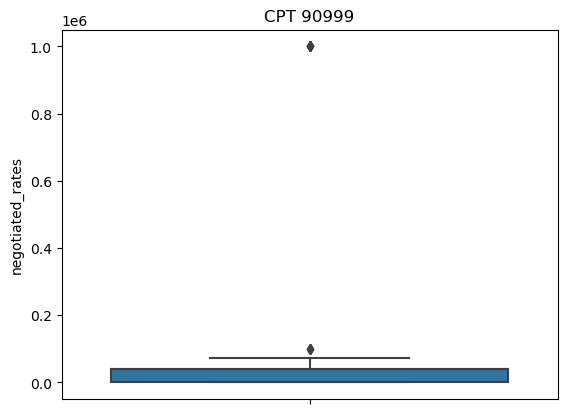

65/68 data points remain for CPT 90999.


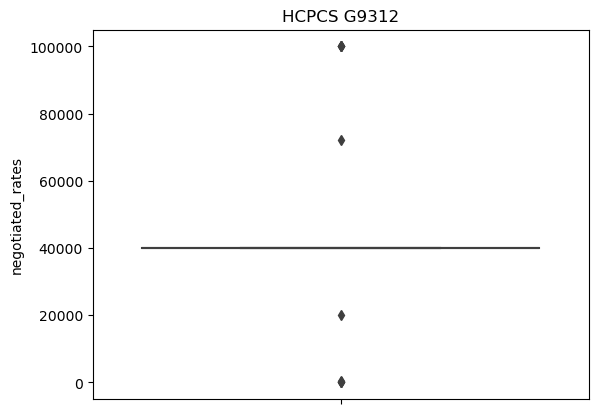

41/44 data points remain for HCPCS G9312.


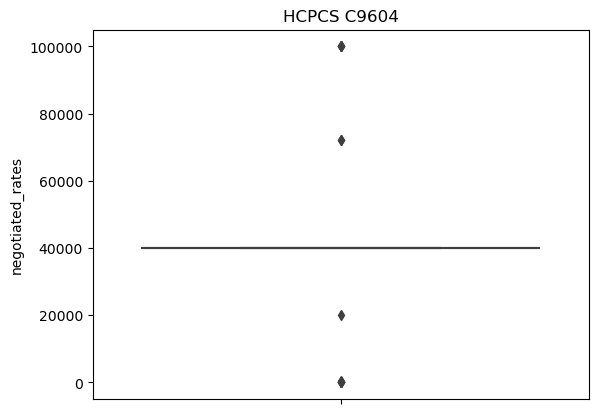

44/46 data points remain for HCPCS C9604.


In [353]:
procedures = df['Procedure'].unique()
df_dict = {}
for p in procedures:
    df_temp = df[df['Procedure'] == p].reset_index()
    temp = df_temp['negotiated_rates']
    plt.figure()
    ro = temp.between(temp.quantile(.05), temp.quantile(.95))
    index_names = df_temp[~ro].index
    df_temp.drop(index_names, inplace=True)
    sns.boxplot(y="negotiated_rates",data=df_temp)
    plt.title(p)
    plt.show()
    print(str(temp[ro].size) + '/' + str(temp.size) + ' data points remain for '+ p +'.')
    df_dict[p]= df_temp



### Remove the following codes:

Due to few number of these operations, we will remove them.

HCPCS C9604 and HCPCS G9312

CPT 581580 would be an interesting place to start. 

In [354]:
procedure = 'CPT 58150'
df_temp = df_dict[procedure]

count = np.sum(df_temp.duplicated(subset=['ccn'], keep='last'))
print(count)

815


In [355]:
for p, df_temp in df_dict.items():
    count = np.sum(df_temp.duplicated(subset=['ccn'], keep='last'))
    print('Number of repeats in ' + p + ' : ' + str(count) + '/'+ str(df_temp['Procedure'].size) + 
          '\tNumber of True Samples: '+ str(df_temp['Procedure'].size - count))

Number of repeats in CPT 36556 : 1241/1671	Number of True Samples: 430
Number of repeats in CPT 51701 : 1248/1674	Number of True Samples: 426
Number of repeats in CPT 51702 : 1247/1676	Number of True Samples: 429
Number of repeats in HCPCS A4314 : 364/787	Number of True Samples: 423
Number of repeats in HCPCS A4315 : 360/784	Number of True Samples: 424
Number of repeats in CPT 58150 : 815/1248	Number of True Samples: 433
Number of repeats in CPT 15920 : 812/1245	Number of True Samples: 433
Number of repeats in CPT 35800 : 803/1235	Number of True Samples: 432
Number of repeats in HCPCS J1650 : 224/646	Number of True Samples: 422
Number of repeats in CPT 71045 : 1910/2345	Number of True Samples: 435
Number of repeats in CPT 99285 : 939/1604	Number of True Samples: 665
Number of repeats in CPT 85025 : 570/1008	Number of True Samples: 438
Number of repeats in CPT 80053 : 545/978	Number of True Samples: 433
Number of repeats in CPT 36415 : 411/853	Number of True Samples: 442
Number of repea

In [356]:
for p, df_temp in df_dict.items():
    df_temp['negotiated_rates_median'] = df_temp.groupby('ccn')['negotiated_rates'].transform('median')
    df_temp.drop_duplicates(subset=['ccn','negotiated_rates_median'],inplace=True)
    df_temp.drop(['negotiated_rates'],axis=1,inplace=True)
    df_temp.drop(remove,axis=1,inplace=True)
    df_temp[missing_mean] = df[missing_mean].fillna(df[missing_mean].mean())
    df_temp[missing_zero] = df[missing_zero].fillna(0)
    df_temp.reset_index()


In [357]:
df_dict[procedure].head()

,index,ccn,Procedure,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,...,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Number of Beds For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates_median
0,51,290003,CPT 58150,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,...,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,424.0,140216.153846,32823.928571,1183.030
10,220,290039,CPT 58150,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,...,0.109,31.44,363.0,22906.758242,126428.379121,126462.472527,424.0,140216.153846,22906.758242,1153.145
29,393,290007,CPT 58150,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,...,0.109,31.44,498.0,22271.000000,118028.000000,126462.472527,424.0,140216.153846,22271.000000,1013.590
34,434,360144,CPT 58150,OH,U,0.13266,0.184709,0.114236,1.56662,0.650623,...,0.109,31.44,172.0,7405.288462,35116.208791,126462.472527,424.0,140216.153846,7405.288462,949.300
35,489,100168,CPT 58150,FL,U,0.13266,0.184709,0.114236,1.56662,0.650623,...,0.109,31.44,370.0,17098.846154,93744.835165,126462.472527,424.0,140216.153846,17098.846154,1205.165


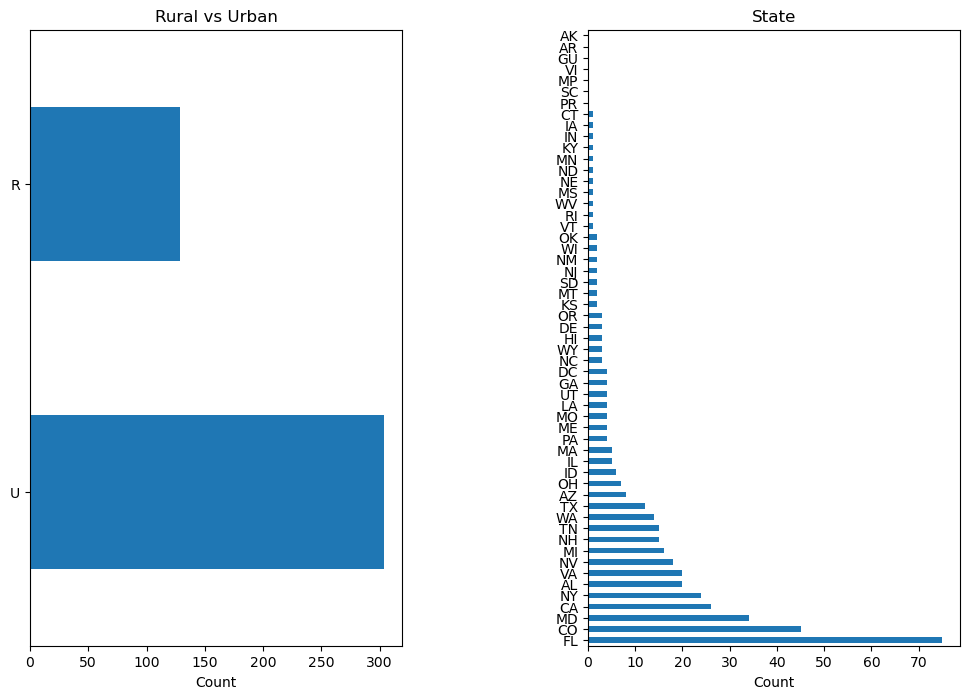

In [358]:
df_dict[procedure]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
df_dict[procedure]['Rural Versus Urban'].value_counts().plot(kind='barh', ax=ax[0])
ax[0].set_title('Rural vs Urban')
ax[0].set_xlabel('Count')
df_dict[procedure]['State Code'].value_counts().plot(kind='barh', ax=ax[1])
ax[1].set_title('State')
ax[1].set_xlabel('Count')
plt.subplots_adjust(wspace=0.5);

Text(0.5, 0, 'Price ($)')

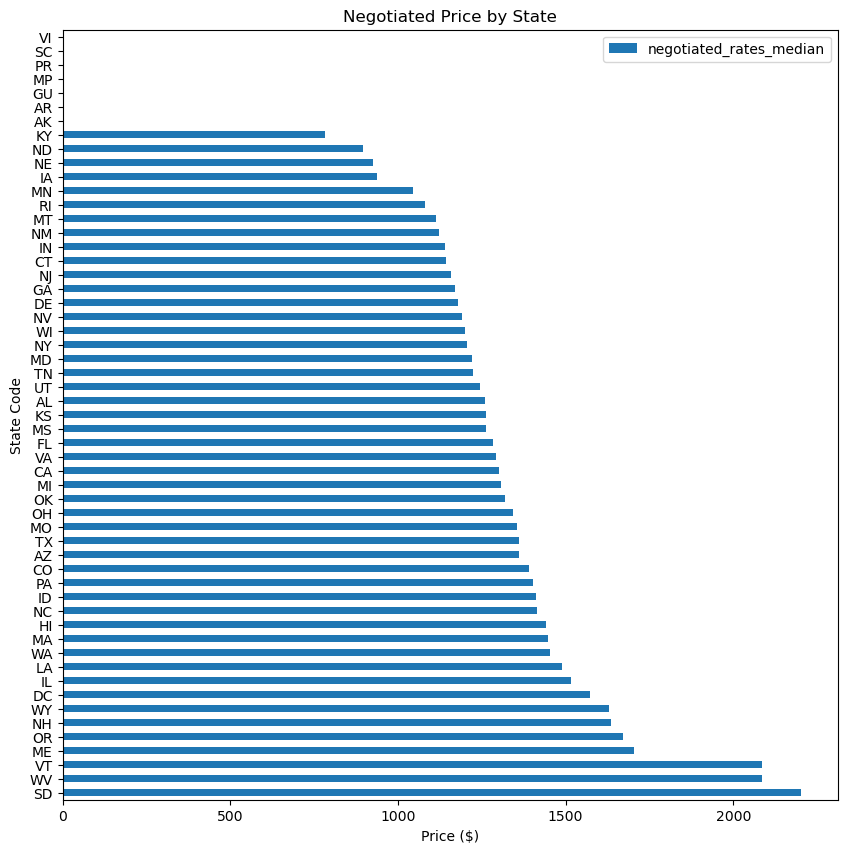

In [359]:
state_price_means = df_dict[procedure].groupby(by='State Code')[['negotiated_rates_median']].mean()
(state_price_means.reindex(index=state_price_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Negotiated Price by State'))
plt.xlabel('Price ($)')

In [360]:
prices = pd.melt(df_dict[procedure][['State Code', 'negotiated_rates_median']], 
                        id_vars='State Code', 
                        var_name='rate', 
                        value_vars=['negotiated_rates_median'], 
                        value_name='Price')
prices.head()

,State Code,rate,Price
0,NV,negotiated_rates_median,1183.030
1,NV,negotiated_rates_median,1153.145
2,NV,negotiated_rates_median,1013.590
3,OH,negotiated_rates_median,949.300
4,FL,negotiated_rates_median,1205.165


Text(0.5, 0, 'State')

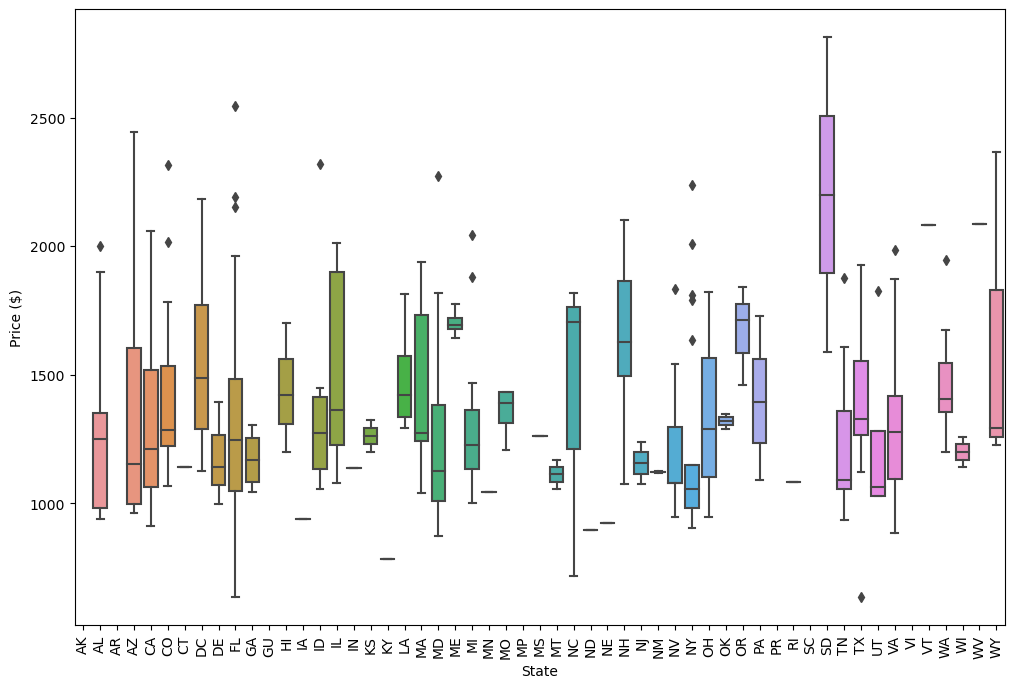

In [361]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='State Code', y='Price', data=prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State')

Text(0.5, 0, 'State')

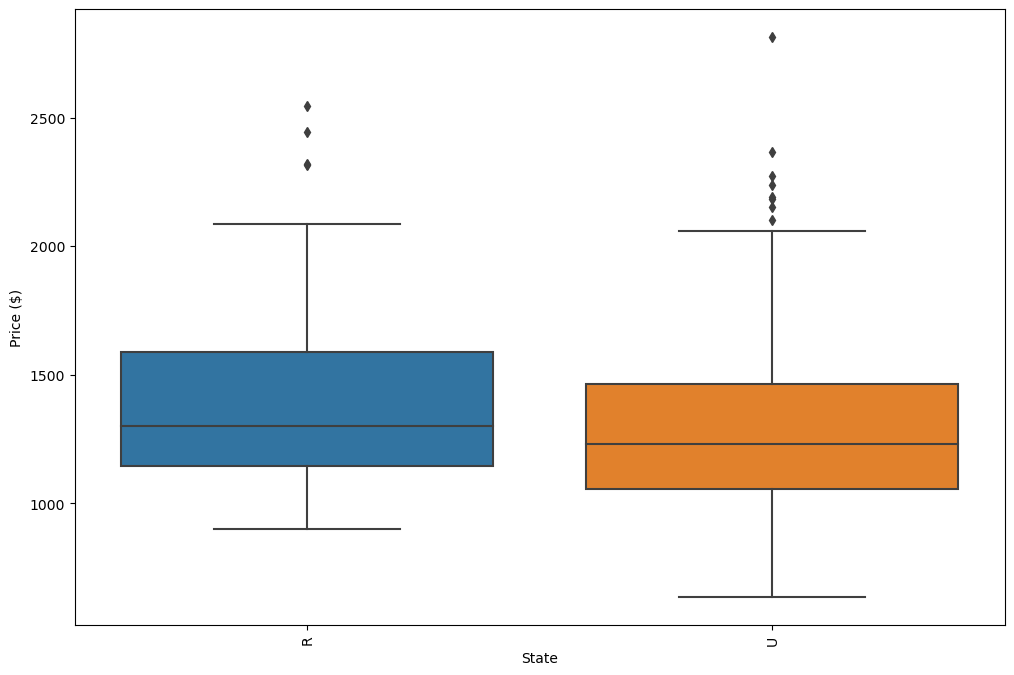

In [362]:
prices_ur = pd.melt(df_dict[procedure][['Rural Versus Urban', 'negotiated_rates_median']], 
                        id_vars='Rural Versus Urban', 
                        var_name='rate', 
                        value_vars=['negotiated_rates_median'], 
                        value_name='Price')

plt.subplots(figsize=(12, 8))
sns.boxplot(x='Rural Versus Urban', y='Price', data=prices_ur)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State')

In [363]:
df_dict[procedure].describe().T

,count,mean,std,min,25%,50%,75%,max
index,433.0,10486.905312,5781.092766,51.000000,5262.000000,11568.000000,15453.000000,19310.000000
PSI_03,433.0,0.571472,0.744550,0.021928,0.132660,0.282079,0.662176,2.915921
PSI_06,433.0,0.179762,0.021200,0.134982,0.163136,0.184709,0.197895,0.240431
PSI_08,433.0,0.090090,0.044282,0.026712,0.052528,0.088072,0.107206,0.222998
PSI_09,433.0,2.190824,0.472846,1.513829,1.938577,2.154881,2.363113,3.390796
PSI_10,433.0,1.051114,0.637537,0.425951,0.721262,0.825515,1.005791,3.064857
PSI_11,433.0,8.169981,4.381372,2.560221,4.533674,6.828991,10.679905,15.563100
PSI_12,433.0,3.240759,1.043217,2.026761,2.598976,3.124478,3.470817,5.434220
PSI_13,433.0,4.496481,1.072914,2.944751,3.864715,4.151716,4.568572,7.339288
PSI_14,433.0,0.775605,0.095126,0.576359,0.693138,0.791150,0.868659,1.045157


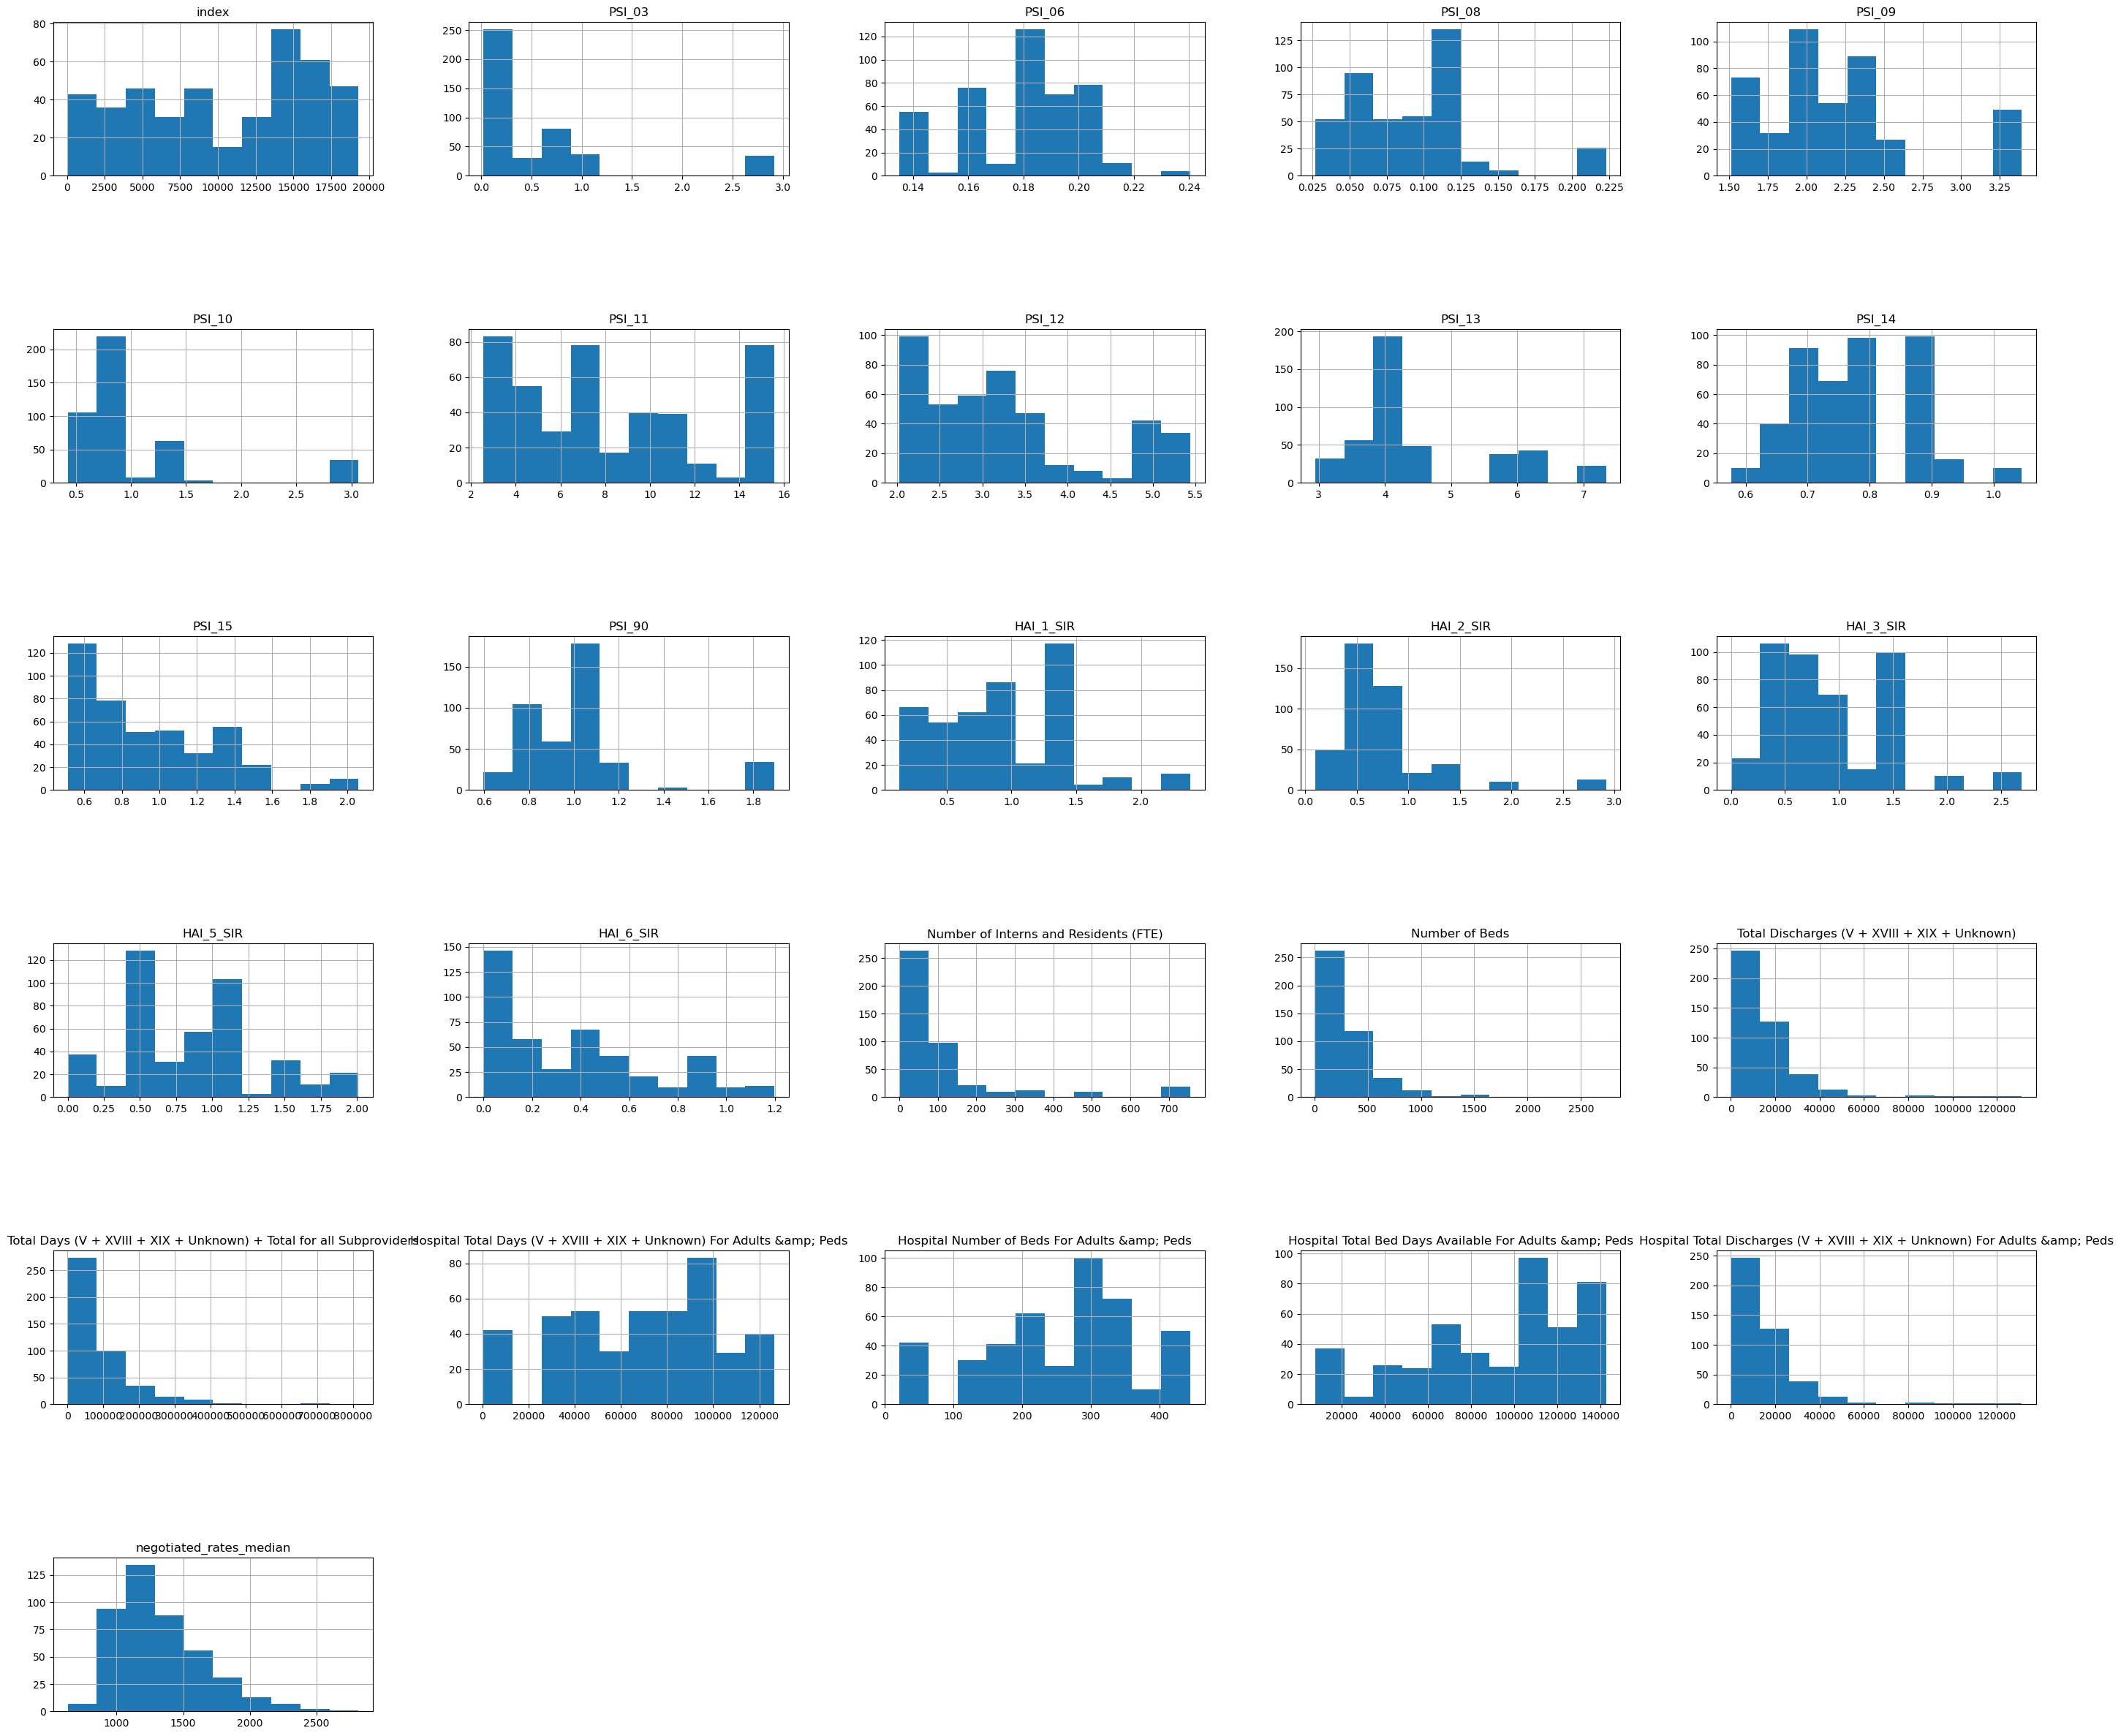

In [364]:
df_dict[procedure].hist(figsize=(35,30))
plt.subplots_adjust(hspace=1);

In [375]:
states_url = 'https://simple.wikipedia.org/w/index.php?title=List_of_U.S._states&oldid=7168473'
usa_states = pd.read_html(states_url)
usa_states = usa_states[0]
usa_states_sub = usa_states.iloc[:, [0,1,5]].copy()
usa_states_sub.columns = ['state','code','state_population']
usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)
usa_states_sub.state.replace(to_replace='\ʻ', value='', regex=True, inplace=True)
usa_states_sub.state[usa_states_sub.state.str.contains('Massachusetts|Pennsylvania|Rhode Island|Virginia|Hawaii')]


10           Hawaii
20    Massachusetts
37     Pennsylvania
38     Rhode Island
45         Virginia
47    West Virginia
Name: state, dtype: object

In [376]:
income_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income#States_and_territories_ranked_by_median_household_income'
income = pd.read_html(income_url)
income = income[1]
income_state = income.iloc[:,[1,2]].copy()
income_state.columns = ['state','salary']
income_state['salary'] = income_state['salary'].str.replace(r'\D','')
income_state['salary'] = income_state['salary'].astype('int')
state_df = usa_states_sub.merge(income_state,how='left',on='state')

C:\Users\Vignesh Selvakumaran\AppData\Local\Temp\ipykernel_16496\293939121.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  income_state['salary'] = income_state['salary'].str.replace(r'\D','')


In [377]:
state_df.head()

,state,code,state_population,salary
0,Alabama,AL,4903185,51734
1,Alaska,AK,731545,75463
2,Arizona,AZ,7278717,62055
3,Arkansas,AR,3017804,48952
4,California,CA,39512223,80440


In [378]:
state_hospital_path = 'Hospital_Metrics\state_metrics.xlsx'
hospital = pd.read_excel(state_hospital_path)
hospital.drop(hospital.index[0], axis=0, inplace=True)
hospital[['code','State']]=hospital['State'].str.split('-',expand=True)
hospital.drop(['State','Gross Patient', 'Patient'], axis=1, inplace=True)
hospital['code']= hospital['code'].str.strip()
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 1 to 57
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Number   57 non-null     float64
 1   Staffed  57 non-null     float64
 2   Total    57 non-null     float64
 3   code     57 non-null     object 
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


In [379]:
state_df = state_df.merge(hospital,how='left',on='code')

In [380]:
state_df

,state,code,state_population,salary,Number,Staffed,Total
0,Alabama,AL,4903185,51734,90.0,15046.0,526562.0
1,Alaska,AK,731545,75463,11.0,1288.0,44563.0
2,Arizona,AZ,7278717,62055,76.0,13870.0,600818.0
3,Arkansas,AR,3017804,48952,52.0,7859.0,306902.0
4,California,CA,39512223,80440,336.0,74451.0,2971759.0
5,Colorado,CO,5758736,77127,59.0,8396.0,383986.0
6,Connecticut,CT,3565278,78833,35.0,8722.0,342235.0
7,Delaware,DE,973764,70176,8.0,2112.0,95952.0
8,Florida,FL,21477737,59227,221.0,57018.0,2487846.0
9,Georgia,GA,10617423,61980,112.0,22390.0,892946.0
